In [1]:
from __future__ import division

import pandas as pd

import scipy as sp
import numpy as np

import matplotlib.pyplot as plt
from hyperopt import hp, tpe, Trials, fmin
from IPython.display import display, Math


from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV

Estatística não paramétrica é um ramo da estatística preocupado com a análise de dados sem assumir que os dados são gerados a partir de qualquer distribuição de probabilidade particular. Uma vez que fazem menos suposições sobre o processo que gerou os dados, os testes não paramétricos são geralmente mais aplicáveis ​​do que seus equivalentes paramétricos. Métodos não paramétricos também são geralmente mais robustos do que suas contrapartes paramétricas. Essas vantagens são balanceadas pelo fato de que quando os dados são gerados por uma distribuição de probabilidade conhecida, os testes paramétricos apropriados são mais [poderosos](http://en.wikipedia.org/wiki/Parametric_statistics).

Neste artigo, vamos explorar uma abordagem bayesiana para regressão não paramétrica, que nos permite modelar funções complexas com suposições relativamente fracas.

####  Uma priori em funções


Estudaremos o modelo $ y = f (x) + \varepsilon $, onde $ f $ é a verdadeira função de regressão que desejamos modelar e $ \varepsilon $ é o ruído gaussiano. Dadas as observações $ (x_1, y_1), \ldots, (x_n, y_n) $ deste modelo, desejamos prever o valor de $ f $ nos novos valores de $ x $. Seja $ X = (x_1, \ldots, x_n) ^ \top $ o vetor coluna dos $ x $ -valores observados e, da mesma forma, seja $ Y = (y_1, \ldots, y_n) ^ \top $. Nosso objetivo é usar essas observações para prever o valor de $ f $ em qualquer ponto com o máximo de precisão possível.

A abordagem Bayesiana para este problema é calcular a [distribuição preditiva posterior](http://en.wikipedia.org/wiki/Posterior_predictive_distribution), $ p (f_ * | X, Y, x _ *) $ do valor de $ f $ em um ponto $ x _ * $. Com esta distribuição em mãos, nós, se necessário, empregamos maquinário de teoria da decisão para produzir estimativas pontuais para o valor de $ f $ em $ x _ * $.

Como a abordagem não paramétrica faz o mínimo possível de suposições sobre a função de regressão, um primeiro passo natural parece ser colocar uma distribuição anterior $\pi(f) $ em todas as funções de regressão possíveis. Neste caso, a distribuição preditiva posterior é

$$\begin{align*}
p(f_* | X, Y, x_*)
    & = \int_f p(f_* | f, x_*)\ p(f | X, Y)\ df \\
    & \propto \int_f p(f_* | f, x_*)\ p(Y | f, X)\ \pi(f) df.
\end{align*}$$

Leitores observadores certamente notaram que acima nos integramos com relação a uma medida não especificada $ df $. Se fizermos a suposição frequentemente razoável de que $ f $ é contínua em um intervalo compacto $ [0, T] $ (para $ T <\infty $), podemos escolher $ df $ como a [medida de Weiner](http://en.wikipedia.org/wiki/Classical_Wiener_space#Classical_Wiener_measure), que está intimamente relacionado ao [movimento browniano](http://en.wikipedia.org/wiki/Brownian_motion). Infelizmente, essa abordagem tem algumas desvantagens. Primeiro, pode ser difícil escolher uma priori decente nas funções contínuas no intervalo $ [0, T] $ (mesmo o prior uniforme será impróprio). Mesmo que consigamos escolher um bom anterior, a integral em relação à medida de Weiner pode não ser fácil (ou mesmo possível) de calcular ou aproximar.

#### Processos Gaussianos

A principal compreensão sobre esta situação que nos permite contornar a dificuldade de calcular a distribuição preditiva posterior da maneira detalhada acima é considerar a distribuição conjunta dos valores observados e previstos de $ f $. Suponha que, dadas nossas observações, desejamos prever o valor de $ f $ nos pontos $ x _ {*, 1}, \ldots x _ {*, m} $. Novamente, seja $ X_ * = (x _ {*, 1}, \ldots, x _ {*, m}) ^ \top $ e $ Y_ * = (f (x _ {*, 1}), \ldots, f ( x _ {*, m})) ^ \top $. Com essa notação, queremos modelar a distribuição conjunta das variáveis ​​aleatórias $ Y $ e $ Y _ * $. Depois de escolher uma distribuição conjunta, podemos condicionar o valor observado de $ Y $ (e $ X $ e $ X _ * $) para obter uma distribuição preditiva posterior para $ Y _ * $. Nessa abordagem, a especificação da distribuição conjunta de $ Y $ e $ Y _ * $ substituiu a especificação de uma distribuição anterior nas funções de regressão.

Obtemos um modelo flexível para a distribuição conjunta de $ Y $ e $ Y _ * $ considerando o conjunto $ \{f (x) | x \in \mathbb {R} \} $ para ser um [Processo Gaussiano](http://en.wikipedia.org/wiki/Gaussian_process). Ou seja, para qualquer número finito de pontos $ x_1, \ldots, x_n \in \mathbb {R} $, as variáveis aleatórias $ f (x_1), \ldots, f (x_n) $ têm uma [distribuição normal multivariada](http://en.wikipedia.org/wiki/Multivariate_normal_distribution). Embora à primeira vista possa parecer que modelar $ f $ com um processo Gaussiano é uma abordagem paramétrica para o problema, o vetor médio e a matriz de covariância da normal multivariada (geralmente) dependem explicitamente dos pontos $ x_1, \ldots, x_n $, tornando esta abordagem é bastante flexível e não paramétrica. O processo gaussiano para $ f $ é especificado por uma função de média $ m (x) $ e uma função de covariância $ k (x, x ') $. Neste contexto, escrevemos que $ f \sim GP (m, k) $. A vantagem dessa abordagem é que o modelo de processo gaussiano é bastante flexível, devido à capacidade de especificar diferentes funções de média e covariância, enquanto ainda permite o cálculo exato das previsões.

Vamos supor que a média do nosso processo gaussiano é zero; veremos que esta não é uma suposição terrivelmente restritiva. Muito mais importante do que a escolha de uma função média é a escolha de uma função de covariância, $ k $. Em geral, $ k $ deve ser [positiva-definida](http://en.wikipedia.org/wiki/Positive-definite_matrix) no sentido de que para qualquer $ X = (x_1, \ldots x_n) $, $ k (X, X) = (k (x_i, x_j)) _ {i, j} $ é uma matriz definida positiva. Esta restrição é necessária para que as matrizes de covariância das distribuições normais multivariadas obtidas do processo gaussiano sejam sensíveis. Existem [muitas](http://en.wikipedia.org/wiki/Gaussian_process#Usual_covariance_functions) opções de função de covariância para listar em detalhes aqui. Usaremos a função de covariância exponencial quadrada comum,

$$ k (x, x ') = \tau^2 * \exp \left (- \frac {(x - x') ^ 2} {2 \ell ^ 2} \right). $$

O parâmetro $ \ell $ controla a rapidez com que a função $ f $ pode oscilar. Valores pequenos de $ \ell $ permitem que $ f $ flutue rapidamente, enquanto valores grandes de $ \ell $ permitem que $ f $ flutue lentamente. O diagrama a seguir mostra exemplos de processos gaussianos com diferentes valores de $ \ell $. $ \tau $ determina a variação dos valores da função de sua média. Valores pequenos de $\tau$ caracterizam funções que ficam próximas de seu valor médio, valores maiores permitem mais variação. Se a variação do sinal for muito grande, a função modelada estará livre para perseguir outliers.

In [2]:
def k(x1, x2, l=1.0, tau = 1.0):
    return (tau**2) * np.exp(-np.subtract.outer(x1, x2)**2 / (2 * l**2))

In [3]:
def sample_gp(xs, m=None, k=k, l=1.0, size=1, tau = 1.0):
    if m is None:
        mean = np.zeros_like(xs)
    else:
        mean = m(xs)
    
    cov = k(xs, xs, l, tau)
        
    samples = np.random.multivariate_normal(mean, cov, size=size)
    
    if size == 1:
        return samples[0]
    else:
        return samples

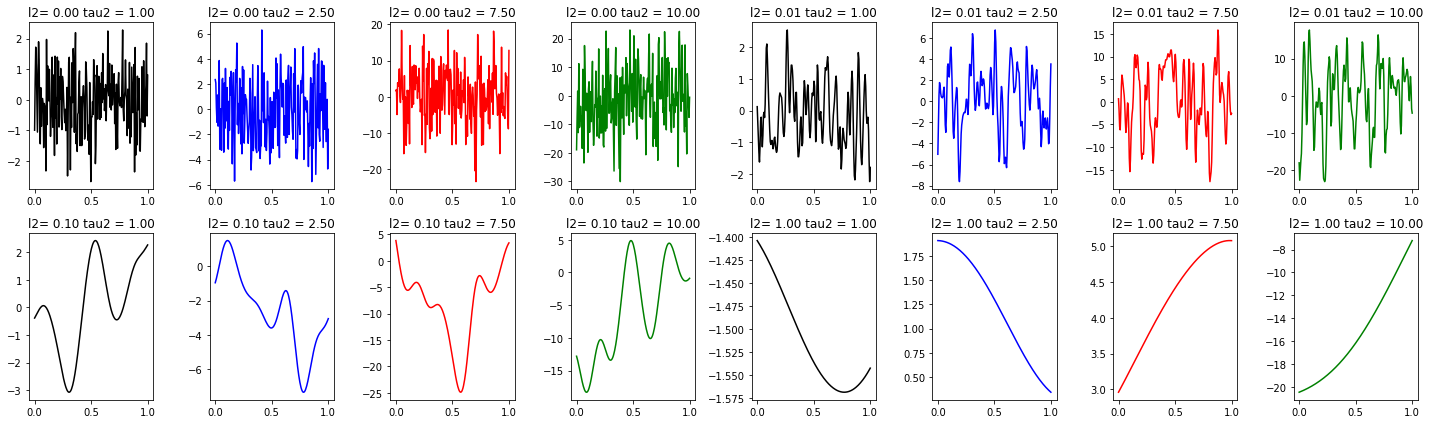

In [4]:
xs = np.linspace(0, 1, 200)
ls = [0.001, 0.01, 0.1, 1]
taus =[ 1, 2.5, 7.5, 10.0]
idx = [[l, t] for l in ls for t in taus]

fig, axes = plt.subplots(2, 8, figsize=(20, 6))
axes = axes.ravel()

colors = ['k', 'b', 'r', 'g']
j = 0
for i in idx :#in # l, tau, ax, color in zip(ls, taus, axes, colors):

    ys = sample_gp(xs, l=i[0], tau = i[1])
    axes[j].plot(xs, ys, color=colors[j%4]);
    axes[j].set_title('l2= {:.2f} tau2 = {:.2f}'.format(i[0],i[1]));
    j = j+1
    
fig.tight_layout();

#### Regressão do Processo Gaussiano

Agora que introduzimos os fundamentos dos processos gaussianos, é hora de usá-los para a regressão. Usando a notação acima, a distribuição conjunta de $ Y $, os valores de $ f $ nos pontos observados, e $ Y _ * $, os valores de $ f $ nos pontos a serem previstos, é normal com média zero e matriz de covariância

$$ \Sigma = \begin {pmatrix}
k (X, X) + \sigma ^ 2 I & k (X, X_ *) \\
k (X_ *, X) & k (X_ *, X_ *)
\end {pmatrix}. $$

Em $ \Sigma $, apenas o bloco superior esquerdo contém um termo de ruído. Os blocos superior direito e inferior esquerdo não têm termo de ruído porque as entradas de $ Y $ e $ Y _ * $ não estão correlacionadas (já que o ruído é i.i.d). O bloco inferior direito não tem termo de ruído porque queremos prever o valor real de $ f $ em cada ponto $ x_ *, i $, não seu valor mais ruído.

Aplicando a distribuição condicional nas observações $ Y = y $, obtemos $ Y_ * | Y = y $ é normal com média $ \mu_y = k (X_ *, X) (k (X, X) + \sigma ^ 2 I) ^ {- 1} y $ e covariância $ \Sigma_y = k (X_ * , X_ *) - k (X_ *, X) (k (X, X) + \sigma ^ 2 I) ^ {- 1} k (X, X _ *) $.

#### Aplicação

Usaremos a regressão do processo Gaussiano para modelar a função $ f (x) = 5 \cos x + \sin 5 x $ no intervalo $ [0, \pi] $, com i.i.d. Ruído gaussiano com desvio padrão $ \sigma = 0,2 $ usando 50 amostras.

In [5]:
def f(x):
    return 5 * np.cos(x) + np.sin(5 * x)

In [6]:
n = 50
sigma = 0.2

sample_xs = sp.stats.uniform.rvs(scale=np.pi, size=n)
sample_ys = f(sample_xs) + sp.stats.norm.rvs(scale=sigma, size=n)
xs = np.linspace(0, np.pi, 100)

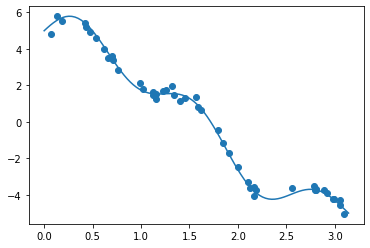

In [7]:
fig, ax = plt.subplots()
ax.scatter(sample_xs, sample_ys);
ax.plot(xs, f(xs));

A classe a seguir implementa esta abordagem para a regressão do processo Gaussiano como uma subcasse de ['sklearn.base.BaseEstimator'](http://scikit-learn.org/dev/modules/generated/sklearn.base.BaseEstimator.html) do` scikit-learn` .

In [8]:
class GPRegression(BaseEstimator):
    def __init__(self, l=1.0, tau = 1.0, sigma=0.0):
        self.l = l
        self.tau = tau
        self.sigma = sigma
    
    def confidence_band(self, X, alpha=0.05):
        """
        Calculates pointwise confidence bands with coverage 1 - alpha
        """
        mean = self.mean(X)
        cov = self.cov(X)
        std = np.sqrt(np.diag(cov))
        
        upper = mean + std * sp.stats.norm.isf(alpha / 2)
        lower = mean - std * sp.stats.norm.isf(alpha / 2)
        
        return lower, upper
    
    def cov(self, X):
        return k(X, X, self.l, self.tau) - np.dot(k(X, self.X, self.l, self.tau), 
                                 np.dot(np.linalg.inv(k(self.X, self.X, self.l, self.tau) 
                                                      + self.sigma**2 * np.eye(self.X.size)),
                                        k(self.X, X, self.l, self.tau)))
    
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def mean(self, X):
        return np.dot(k(X, self.X, self.l, self.tau),
               np.dot(np.linalg.inv(k(self.X, self.X, self.l, self.tau)
                        + self.sigma**2 * np.eye(self.X.size)),
                      self.y))
    
    def predict(self, X):
        return self.mean(X)

Usar `BaseEstimator`como subclasse nos permite usar ferramentas de validação cruzada do `scikit-learn`  para escolher os valores dos hiperparâmetros $ \ell $ , $\tau$ e $ \sigma $.

In [9]:
%%time
gp = GPRegression()
param_grid = {
              'l': np.linspace(0.01, 0.6, 50),
              'tau': np.linspace(0.01, 10, 50),
              'sigma': np.linspace(0, 0.5, 50)
              }

cv = GridSearchCV(gp, param_grid, scoring='neg_mean_squared_error')
cv.fit(sample_xs, sample_ys);

CPU times: user 14min 21s, sys: 9min 14s, total: 23min 35s
Wall time: 12min 38s


A validação cruzada produz os seguintes parâmetros, que produzem um erro quadrático médio relativamente pequeno.

In [10]:
model = GPRegression(**cv.best_params_)
model.fit(sample_xs, sample_ys)
cv.best_params_

{'l': 0.6, 'sigma': 0.39795918367346933, 'tau': 7.75734693877551}

In [11]:
def f_obj_1 (a0, a1, w0,w1, f0, f1):
    return a0 * np.cos(w0*xs + f0)+ a1 * np.sin(w1*xs + f1)


def f_obj (a0, a1, w0,w1, f0, f1):
    return a0 * np.cos(w0*sample_xs + f0)+ a1 * np.sin(w1*sample_xs + f1)
def objective(a0, a1, w0,w1, f0, f1):
    """Objective function to minimize"""
    return np.mean((f_obj(a0, a1, w0,w1, f0, f1) - sample_ys)**2)

def objective2(args):
    return objective(*args)

space = [hp.uniform('a0', 0, 15),
         hp.uniform('a1', 0, 10),
         hp.uniform('w0', 0, 10),                  
         hp.uniform('w1', 0, 10),         
         hp.uniform('f0', -np.pi, np.pi), 
         hp.uniform('f1', -np.pi, np.pi)]

tpe_algo = tpe.suggest
tpe_trials = Trials()

tpe_best = fmin(fn=objective2, space=space, algo=tpe_algo, trials=tpe_trials, max_evals=500, rstate=np.random.RandomState(42))


100%|██████████| 500/500 [00:09<00:00, 52.67it/s, best loss: 0.5141715290172618]


In [12]:
tpe_best

{'a0': 0.010342606625680872,
 'a1': 4.582365072535992,
 'f0': -0.25047313404182125,
 'f1': 1.1973382813687254,
 'w0': 6.118700206961882,
 'w1': 1.2602198266823321}

A figura abaixo mostra a verdadeira função de regressão, $ f (x) = 5 \cos x + \sin 5 x $ junto com nossa estimativa de regressão do processo Gaussiano. Ele também mostra uma banda de confiança pontual de 95% em torno da função de regressão estimada.

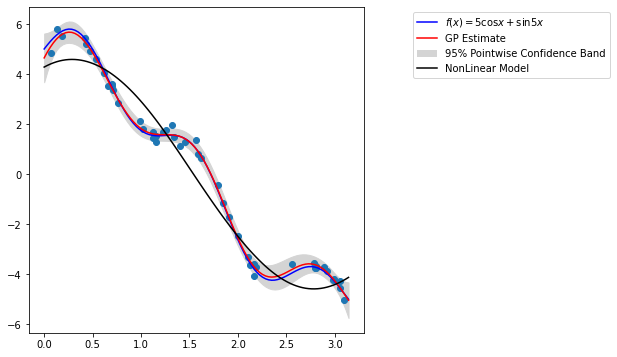

In [13]:
lower, upper = model.confidence_band(xs)
fig, ax = plt.subplots(figsize=(6, 6))

ax.fill_between(xs, lower, upper, color='#D4D4D4', );
regression_line, = ax.plot(xs, f(xs), color='blue', label='$f(x) = 5 \cos x + \sin 5 x$');
gp_estimate, = ax.plot(xs, model.predict(xs), color='red', label='GP Estimate');
nlm_estimate, = ax.plot(xs, f_obj_1(**tpe_best), color='black', label='NonLinear Model');
ax.scatter(sample_xs, sample_ys);

rect = plt.Rectangle((0, 0), 1, 1, fc='#D4D4D4');

ax.legend([regression_line, gp_estimate, rect,nlm_estimate], ['$f(x) = 5 \cos x + \sin 5 x$', 'GP Estimate', '95% Pointwise Confidence Band',  'NonLinear Model'], bbox_to_anchor=(1.75, 1));

In [14]:
from sklearn.metrics import mean_squared_error
print('Erro quadrático médio - Regressão do Processo Gaussiano:',mean_squared_error(f(xs), model.predict(xs)))
print('Erro quadrático médio - Hyperopt:',mean_squared_error(f(xs), f_obj_1(**tpe_best)))

Erro quadrático médio - Regressão do Processo Gaussiano: 0.01015011649262326
Erro quadrático médio - Hyperopt: 0.5885042665952294


#### 